In [1]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy import interpolate
import datetime
import cmocean
from matplotlib.dates import DateFormatter
from scipy import interpolate, stats
import glob

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m-%d')

In [2]:
def load_netcdf(filepath, in_vars):
    """ open netcdf file, load variables (in_vars should be a list) and
        output dictionary of variables"""
    from netCDF4 import Dataset

    out_vars = {}

    open_netcdf = Dataset(filepath, mode = 'r')
    if len(in_vars)>0:
        for var in in_vars:
            out_vars[var] = open_netcdf.variables[var][:]
    else:
        for var in open_netcdf.variables.keys():
            out_vars[var] = open_netcdf.variables[var][:]

    try:
        out_vars['time_unit'] = open_netcdf.variables['time'].units
    except:
        None
    open_netcdf.close()
    #print(out_vars.keys())
    return out_vars

In [6]:
def calc_skin_temp(lwd,lwu,emis):
    """ From Cox et al 2023: 'For snow, ε was set to 0.985, consistent with other studies (e.g., ref. 13) and justified by 
    the relatively spectrally flat hemispheric infrared emissivity of snow. For the wintertime snow surface, this assumption 
    is likely within 0.5% (~ 0.04 C at MOSAiC), but during summer when the surface type was variably ice, liquid, or melting 
    snow, the actual emissivity may have differed by more.' """
    sigma = 5.670374419*(10.**-8)
    Ts = ( (lwu - (1.-emis)*lwd)/(emis*sigma))**0.25
    return Ts

In [9]:
def calc_swu_correction_no_lwd(swu):
    ## precision matters!!!!
    ## created in Raven_skin-temp_correction.ipynb
    
    correction = swu*0.002350659890433026 - 0.2214795415197989
    return correction

In [12]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

Load SIMBA data

In [3]:
simba_filepath = '/psd3data/arctic/raven/simba/level1/'
lev1_files = glob.glob(simba_filepath+'*.nc')
lev1_files.sort()

## get rid of march files, will also probably want to get rid of first few days of actual data after install as well?
lev1_files = lev1_files[5:]


varnames = ['temperature','height','time']

season_data = {}

for fname in lev1_files[:]:
    fdic = load_netcdf(fname, varnames)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'][-19:], '%Y-%m-%d %H:%M:%S')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(minutes=int(m)) for m in fdic['time']])

    for var in ['temperature','dates']:
        if var not in season_data:
            season_data[var] = fdic[var]
        else:
            season_data[var] = np.ma.concatenate( (season_data[var], fdic[var]), axis=0 )

    ## only want one height:
    if 'height' not in season_data:
        season_data['height'] = fdic['height']
    print(season_data['dates'].shape, season_data['height'].shape, season_data['temperature'].shape)

(96,) (241,) (96, 241)
(192,) (241,) (192, 241)
(288,) (241,) (288, 241)
(384,) (241,) (384, 241)
(480,) (241,) (480, 241)
(576,) (241,) (576, 241)
(672,) (241,) (672, 241)
(768,) (241,) (768, 241)
(864,) (241,) (864, 241)
(960,) (241,) (960, 241)
(1056,) (241,) (1056, 241)
(1152,) (241,) (1152, 241)
(1248,) (241,) (1248, 241)
(1344,) (241,) (1344, 241)
(1440,) (241,) (1440, 241)
(1536,) (241,) (1536, 241)
(1632,) (241,) (1632, 241)
(1728,) (241,) (1728, 241)
(1824,) (241,) (1824, 241)
(1920,) (241,) (1920, 241)
(2016,) (241,) (2016, 241)
(2112,) (241,) (2112, 241)
(2208,) (241,) (2208, 241)
(2304,) (241,) (2304, 241)
(2400,) (241,) (2400, 241)
(2496,) (241,) (2496, 241)
(2592,) (241,) (2592, 241)
(2688,) (241,) (2688, 241)
(2784,) (241,) (2784, 241)
(2880,) (241,) (2880, 241)
(2976,) (241,) (2976, 241)
(3072,) (241,) (3072, 241)
(3168,) (241,) (3168, 241)
(3264,) (241,) (3264, 241)
(3360,) (241,) (3360, 241)
(3456,) (241,) (3456, 241)
(3552,) (241,) (3552, 241)
(3648,) (241,) (3648, 2

In [4]:
# read in manual heights, assess and adjust!
man_heights = np.genfromtxt('/home/asledd/ICECAPS/SLEIGH_SIMBA_manual_sfc_id.csv', delimiter=',', skip_header=3)

## say what's what
sfc_heights = {'dates':np.asarray([ datetime.datetime(int(value[0]),int(value[1]),int(value[2])) for value in man_heights]),
               'surface':np.asarray([ value[3]-2. for value in man_heights])}

In [22]:
print(sfc_heights['dates'][0],sfc_heights['dates'][-1])

2024-05-15 00:00:00 2024-07-25 00:00:00


In [14]:
temp_kelv = season_data['temperature']+273.15
imb_depth = season_data['height']
imb_depth_m = imb_depth/100.

# how best to limit depths?
sfc_height = -350/100. # from thermistor locations at install
bottom_height = -(360+75)/100. # currently lowest level is now bottom flx plate; was set to -470 right now removing bottom thermistor that looks like it might be the air temp?

imb_secs = np.array([(t-datetime.datetime(1970,1,1)).total_seconds() for _,t in np.ndenumerate(season_data['dates'])])

Get "surface" temperatures from manual estimate. Likely to change in the future.

In [23]:
st_date = sfc_heights['dates'][0]
en_date = sfc_heights['dates'][-1]
date_idx_imb = np.where((season_data['dates']>=st_date)&(season_data['dates']<=en_date) )[0]


imb_sfc_temp = []
imb_nr_sfc_temp = []
imb_abv_sfc_temp = []
imb_sfc_dates = []
imb_2abv_sfc_temp = []

for i, t_idx in np.ndenumerate(date_idx_imb[:]):


    close_height_date = nearest(sfc_heights['dates'], season_data['dates'][t_idx])

    depth_idx = np.where((imb_depth_m<=sfc_height/100.)&(imb_depth_m>=-4.75)) # cut off bottom thermistor that's the air temp
 

    ## save for analysis
    try:
        imb_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]])
        imb_nr_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][1]])
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-1])
        imb_2abv_sfc_temp.append(temp_kelv[t_idx, depth_idx[0][0]-2])

    except:
        imb_sfc_temp.append(np.nan)
        imb_nr_sfc_temp.append(np.nan)
        imb_sfc_dates.append(season_data['dates'][t_idx])
        imb_abv_sfc_temp.append(np.nan)
        imb_2abv_sfc_temp.append(np.nan)


## turn into arrays
imb_sfc_temp = np.asarray(imb_sfc_temp)
imb_nr_sfc_temp = np.asarray(imb_nr_sfc_temp)
imb_abv_sfc_temp = np.asarray(imb_abv_sfc_temp)
imb_2abv_sfc_temp = np.asarray(imb_2abv_sfc_temp)

/tmp/ipykernel_1664664/1779483848.py:37: UserWarning: Warning: converting a masked element to nan.
  imb_sfc_temp = np.asarray(imb_sfc_temp)
/tmp/ipykernel_1664664/1779483848.py:38: UserWarning: Warning: converting a masked element to nan.
  imb_nr_sfc_temp = np.asarray(imb_nr_sfc_temp)
/tmp/ipykernel_1664664/1779483848.py:39: UserWarning: Warning: converting a masked element to nan.
  imb_abv_sfc_temp = np.asarray(imb_abv_sfc_temp)
/tmp/ipykernel_1664664/1779483848.py:40: UserWarning: Warning: converting a masked element to nan.
  imb_2abv_sfc_temp = np.asarray(imb_2abv_sfc_temp)


Load in SLEIGH data

In [5]:
# turn into function later
asfs_filepath = '/psd3data/arctic/raven_process/asfs/level1/'
asfs_lev1_files = glob.glob(asfs_filepath+'slow.level1.melt-sleighsfs.*.nc')
asfs_lev1_files.sort()
asfs_lev1_files = asfs_lev1_files[12:] # early files don't have skin_temp_surface?

# vaisala_T_Avg = average of the air temperature during the 1 min averaging interval

lev1_slow_vars = ['ir20_lwd_Wm2_Avg','ir20_lwu_Wm2_Avg','vaisala_T_Avg', 'apogee_targ_T_Avg', 'apogee_body_T_Avg',
                  'sr30_swu_IrrC_Avg', 'sr30_swd_IrrC_Avg', 'ir20_lwu_DegC_Avg',#'skin_temp_surface',
                  'zenith_true','azimuth','spn1_tot_Avg','spn1_dif_Avg',
                  'base_time','time']

asfs_data_lev1 = {}

for fname in asfs_lev1_files[:]:
    print(fname)

    fdic = load_netcdf(fname, lev1_slow_vars)

    fstart_time = datetime.datetime.strptime(fdic['time_unit'], 'seconds since %Y-%m-%dT%H:%M:%S.000000')
    fdic['dates'] = np.asarray([fstart_time+datetime.timedelta(seconds=int(m)) for m in fdic['time']])

    for var in lev1_slow_vars[:-2]+['dates']:
        if var not in asfs_data_lev1:
            asfs_data_lev1[var] = fdic[var]
        else:
            asfs_data_lev1[var] = np.ma.concatenate( (asfs_data_lev1[var], fdic[var]), axis=0 )

/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240528.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240529.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240530.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240531.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240601.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240602.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240603.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240604.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240605.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240606.000000.nc
/psd3data/arctic/raven_process/asfs/level1/slow.level1.melt-sleighsfs.20240607.000000.nc
/psd3data/arctic/rave

In [7]:
asfs_data_lev1['skin_temp_surface'] = calc_skin_temp(asfs_data_lev1['ir20_lwd_Wm2_Avg'],asfs_data_lev1['ir20_lwu_Wm2_Avg'],0.985) - 273.15

In [8]:
## mask a bunch of variables since this is still level1 data
asfs_data_lev1['sr30_swd_IrrC_Avg'] = np.ma.masked_outside(asfs_data_lev1['sr30_swd_IrrC_Avg'], 0,2000)
asfs_data_lev1['sr30_swu_IrrC_Avg'] = np.ma.masked_outside(asfs_data_lev1['sr30_swu_IrrC_Avg'], 0,2000)
asfs_data_lev1['skin_temp_surface'] = np.ma.masked_greater(asfs_data_lev1['skin_temp_surface'], 10)
asfs_data_lev1['ir20_lwu_Wm2_Avg'] = np.ma.masked_outside(asfs_data_lev1['ir20_lwu_Wm2_Avg'], -10,350)


Apply SWU correction for skin temperature

In [10]:
solar_up_correction_nolwd = calc_swu_correction_no_lwd(asfs_data_lev1['sr30_swu_IrrC_Avg'])
solar_up_correction_nolwd[np.where(solar_up_correction_nolwd<0)[0]] = 0.
asfs_data_lev1['skin_temp_correct'] = asfs_data_lev1['skin_temp_surface'] - solar_up_correction_nolwd

Compare "2m" (air) temperature and surface/skin temperatures between SLEIGH and SIMBA

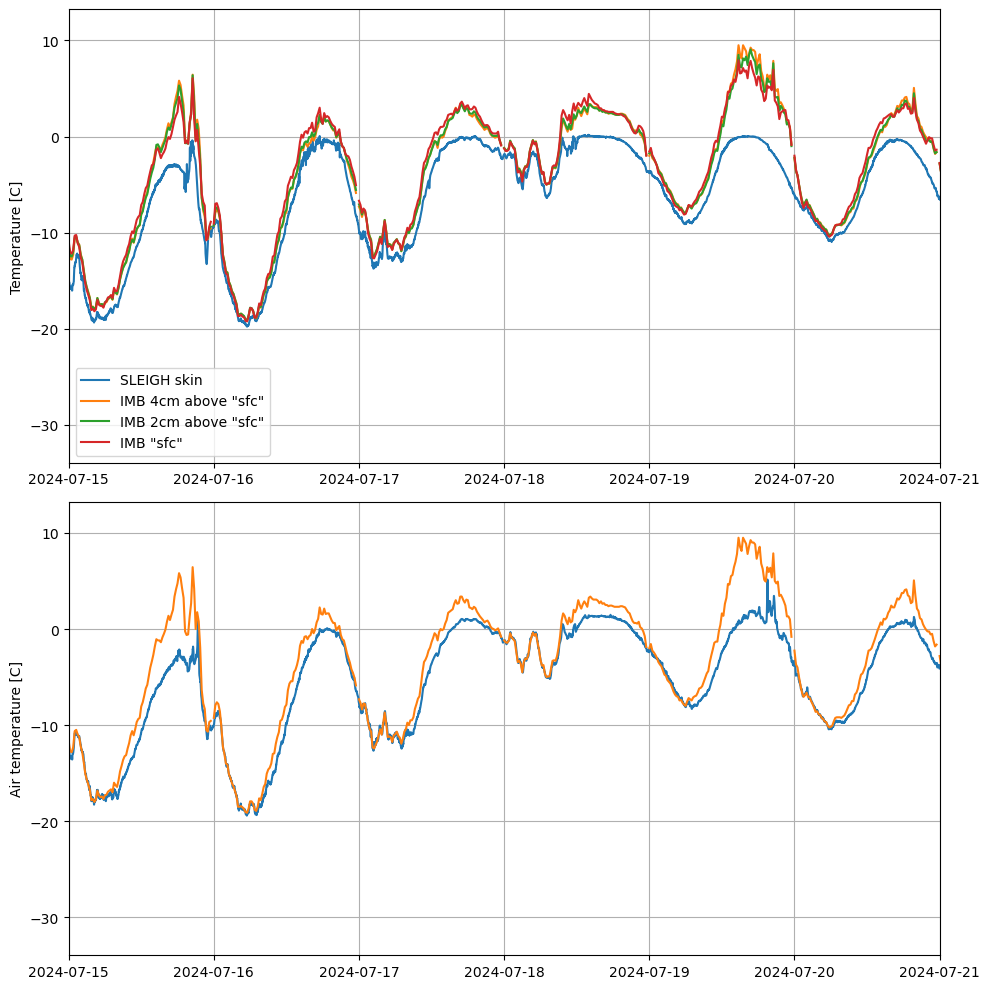

In [30]:
fig, axs = plt.subplots(2, figsize=(10,10))
short_idx = np.where((asfs_data_lev1['dates']>datetime.datetime(2024,5,20))&(asfs_data_lev1['dates']<datetime.datetime(2024,8,1)))[0]
axs[0].plot(asfs_data_lev1['dates'][short_idx], asfs_data_lev1['skin_temp_correct'][short_idx], label='SLEIGH skin')

axs[0].plot(imb_sfc_dates, imb_2abv_sfc_temp-273.15, label='IMB 4cm above "sfc"')
axs[0].plot(imb_sfc_dates, imb_abv_sfc_temp-273.15, label='IMB 2cm above "sfc"')
axs[0].plot(imb_sfc_dates, imb_sfc_temp-273.15, label='IMB "sfc"')
# axs[0].plot(imb_sfc_dates, imb_nr_sfc_temp-273.15, label='IMB 2cm below "sfc"')


axs[1].plot(asfs_data_lev1['dates'][short_idx], asfs_data_lev1['vaisala_T_Avg'][short_idx], label='SLEIGH')
axs[1].plot(season_data['dates'], season_data['temperature'][:,0], label='SIMBA')


for ax in axs.ravel():
    ax.set_xlim(datetime.datetime(2024,7,15), datetime.datetime(2024,7, 21))
    ax.grid()

axs[0].set_ylabel('Temperature [C]')
axs[1].set_ylabel('Air temperature [C]')
# axs[1].set_ylim(0,1200)

axs[0].legend(loc='best')
plt.tight_layout()
# plt.savefig('Raven_2024_SIMBA_sfc-abv-below_SLEIGH_temps_SWD_20240715-20240721.png')
plt.show()

In [31]:
simba_air_temp = season_data['temperature'][:,0]
print(simba_air_temp.shape, asfs_data_lev1['vaisala_T_Avg'][short_idx].shape, asfs_data_lev1['vaisala_T_Avg'].shape)

(9504,) (93600,) (113760,)


### Need to take 15 minute averages of SLEIGH data before comparing with SIMBA? 